In [4]:
import pandas as pd

df = pd.read_excel('./data/credit_card.xls', header=1, sheet_name="Data").iloc[0:, 1:]
print(df.shape)
df.head(3)

(30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [10]:
df.rename(columns={'PAY_0':'PAY_1', 'default payment next month':'default'}, inplace=True)
y_target = df['default']
X_features = df.drop('default', axis=1)

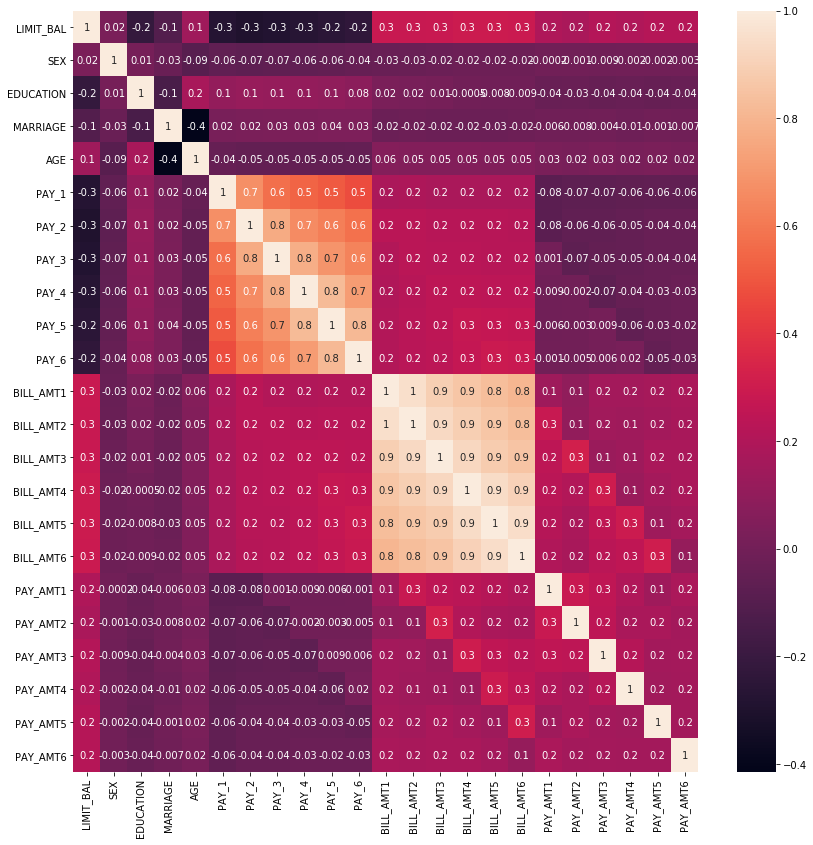

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

corr = X_features.corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr, annot=True, fmt='.1g')

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

cols_bill = ['BILL_AMT'+str(i) for i in range(1, 7)]
print('대상 속성명', cols_bill)

scaler = StandardScaler()
df_cols_scaled = scaler.fit_transform(X_features[cols_bill])
pca = PCA(n_components=2)
pca.fit(df_cols_scaled)
print('PCA Component별 변동성', pca.explained_variance_ratio_)

대상 속성명 ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
PCA Component별 변동성 [0.90555253 0.0509867 ]


In [20]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rcf = RandomForestClassifier(n_estimators=300, random_state=156)
scores = cross_val_score(rcf, X_features, y_target, scoring='accuracy', cv=3)

print('CV=3 인 경우의 개별 Fold세트별 정확도 : ', scores)
print('평균 정확도:{0:.4f}'.format(np.mean(scores)))

CV=3 인 경우의 개별 Fold세트별 정확도 :  [0.8083 0.8196 0.8232]
평균 정확도:0.8170


In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 원본에 먼저 Scaler 적용
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X_features)

# PCA 후 cross_val_score()로 예측 수행
pca = PCA(n_components=6)
df_pca = pca.fit_transform(df_scaled)
scores_pca = cross_val_score(rcf, df_pca, y_target, scoring='accuracy', cv=3)

print('CV=3 인 경우의 PCA 변환된 개별 Fold 세트별 정확도 : ', scores_pca)
print('PCA 변환 데이터 세트 평균 정확도{0:.4f}'.format(np.mean(scores_pca)))

CV=3 인 경우의 PCA 변환된 개별 Fold 세트별 정확도 :  [0.7909 0.7956 0.8021]
PCA 변환 데이터 세트 평균 정확도0.7962


# 고객 세그먼테이션

In [73]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel('./data/Online_Retail.xlsx')
retail_df.head(3)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom


In [74]:
retail_df.rename(columns={'Customer ID':'CustomerID'}, inplace=True)
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   CustomerID   417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [75]:
retail_df = retail_df[retail_df['Quantity']>0]
retail_df = retail_df[retail_df['Price']>0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()


(407664, 8)


Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
CustomerID     0
Country        0
dtype: int64

In [80]:
retail_df['Country']

0         United Kingdom
1         United Kingdom
2         United Kingdom
3         United Kingdom
4         United Kingdom
               ...      
525456    United Kingdom
525457    United Kingdom
525458    United Kingdom
525459    United Kingdom
525460    United Kingdom
Name: Country, Length: 407664, dtype: object

In [5]:
retail_df['Country'].value_counts()[:5]

United Kingdom    370929
EIRE                8507
Germany             7654
France              5470
Netherlands         2729
Name: Country, dtype: int64

In [6]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(370929, 8)


In [7]:
retail_df['sale_amount'] = retail_df['Quantity']*retail_df['Price']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [9]:
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841    5043
14606    3866
12748    2633
17850    2499
16549    2269
Name: CustomerID, dtype: int64
CustomerID
18102    349164.35
13694    131443.19
17511     84541.17
15061     83284.38
16684     80489.21
Name: sale_amount, dtype: float64


In [12]:
retail_df.groupby(['Invoice', 'StockCode'])['Invoice'].count().mean()

1.0351343281082996

## Recency(R) : 가장 최근 상품 구입 일에서 오늘까지의 기간
## Frequency(F): 상품 구매 횟수
## Monetary(M): 총 구매 금액

In [36]:
aggregations = {
    'InvoiceDate' : 'max',
    'Invoice' : 'count',
    'sale_amount' : 'sum'
}

cust_df = retail_df.groupby('CustomerID').agg(aggregations)

cust_df = cust_df.rename(columns={'InvoiceDate':'Recency',
                                  'Invoice':'Frequency',
                                  'sale_amount':'Monetary'
                                 }
                        )

cust_df = cust_df.reset_index()
cust_df.head(3)


,CustomerID,Recency,Frequency,Monetary
0,12346,2010-06-28 13:53:00,33,372.86
1,12608,2010-10-31 10:49:00,16,415.79
2,12745,2010-08-10 10:14:00,22,723.85


In [37]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011, 12, 10)-cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x:x.days+1)
print('cust_df 로우와 칼럼 건수는', cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는 (3969, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,530,33,372.86
1,12608,405,16,415.79
2,12745,487,22,723.85


(array([3.952e+03, 1.200e+01, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([2.9500000e+00, 3.4919090e+04, 6.9835230e+04, 1.0475137e+05,
        1.3966751e+05, 1.7458365e+05, 2.0949979e+05, 2.4441593e+05,
        2.7933207e+05, 3.1424821e+05, 3.4916435e+05]),
 <a list of 10 Patch objects>)

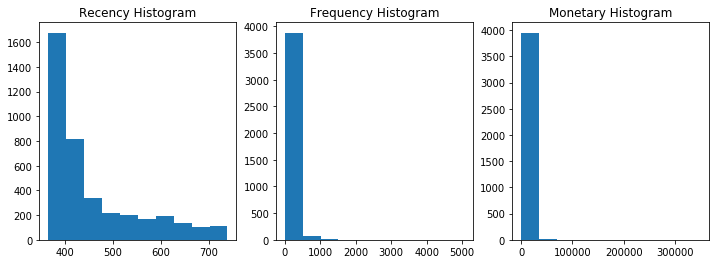

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

In [40]:
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3969.000000,3969.000000,3969.000000
mean,456.095742,93.456538,1868.167287
std,97.072657,183.306124,7380.830030
min,366.000000,1.000000,2.950000
25%,383.000000,18.000000,304.200000
50%,417.000000,43.000000,669.910000
75%,501.000000,102.000000,1655.640000
max,739.000000,5043.000000,349164.350000


## 왜곡이 심할 경우 평균, 표준편차 재조정 필요

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features= cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label']=labels

print('실루엣 스코어: {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어: 0.575


In [49]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성  
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [50]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

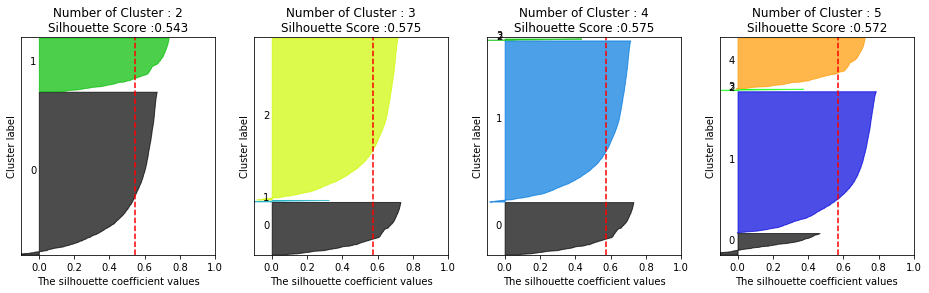

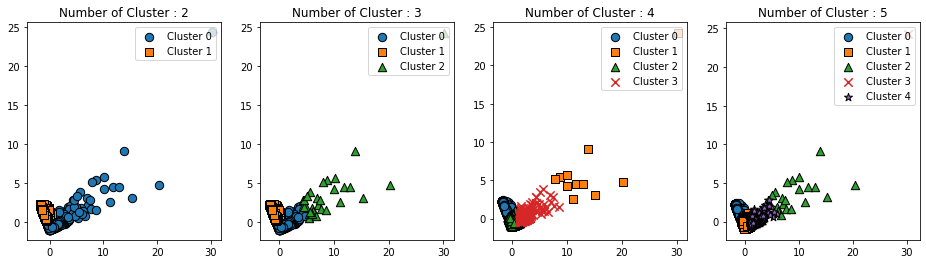

In [51]:
visualize_silhouette([2, 3, 4, 5], X_features_scaled)
visualize_kmeans_plot_multi([2, 3, 4, 5], X_features_scaled)

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# log1p 적용
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# StandardScaler 적용
X_features=cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)

In [63]:
cust_df['cluster_label'] = labels

print('실루엣 스코어 : {0:3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어 : 0.377838


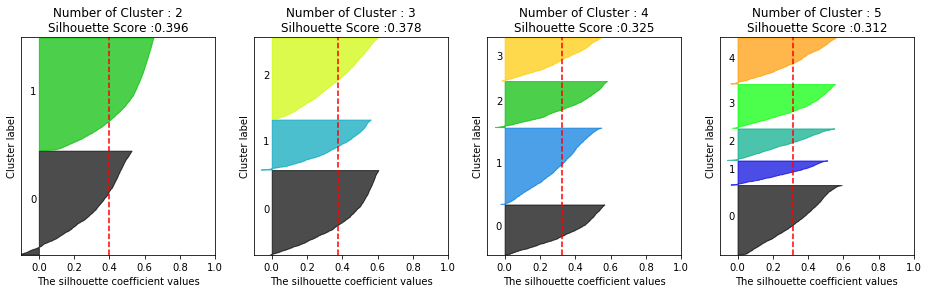

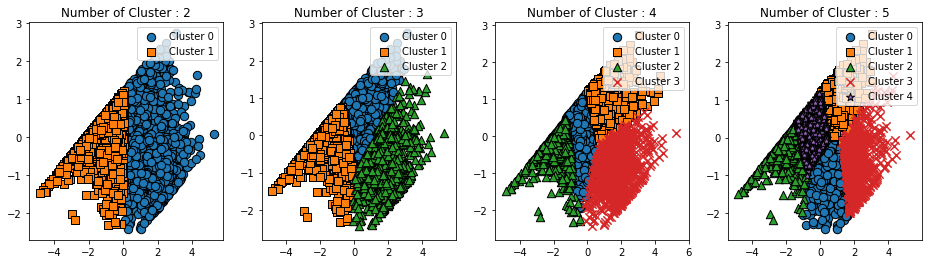

In [64]:
visualize_silhouette([2, 3, 4, 5], X_features_scaled)
visualize_kmeans_plot_multi([2, 3, 4, 5], X_features_scaled)

## 실루엣 스코어의 절대치가 중요한 것은 아님